In [1]:
import os
import rasterio
import geopandas as gpd
import pandas as pd
import time
import numpy as np


In [2]:

starttime = time.time()
#reading in GEDI points
gedi_df = gpd.read_file('../data/GEDI_data/clipped_gedi.gpkg', driver='GPKG', index = True)
endtime = time.time()
print(f"Reading in the GEDI shapefile took {endtime - starttime} seconds")
# print(gedi_df.head())
#reading in ICESat2 shapefile
icesat_df = gpd.read_file('../data/GEDI_data/clipped_icesat.shp', driver='ESRI Shapefile', index = True)
# print(icesat_df.head())


Reading in the GEDI shapefile took 2722.633799314499 seconds


In [3]:
# Get unique values in GeoTIFF column
unique_geotiffs = icesat_df['GeoTIFF'].unique()

# Specify the file location of the TIFF files
tif_folder = 'reprojected_icesat_to_gedi_crs'

gedi_bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
min = np.full((len(gedi_bins)+1), np.inf)
max = np.zeros(len(gedi_bins)+1)
num_points = np.zeros(len(gedi_bins)+1)
mean_helper = np.zeros(len(gedi_bins)+1)
std_helper = np.zeros(len(gedi_bins)+1)

# Iterate over unique GeoTIFF values
for geotiff in unique_geotiffs:
    # Create an empty list to store the data
    list = []
    
    # Construct the file path
    tif_file = os.path.join(tif_folder, geotiff[:-4] + '_reprojected.tif')
    
    # Load the TIFF file using rasterio
    with rasterio.open(tif_file) as icesat_tif:
        # print(icesat_tif)

        filtered_df =  gpd.read_file('../data/GEDI_data/clipped_gedi.gpkg', driver='GPKG', index = True, bbox=icesat_tif.bounds)
        # print(filtered_df.head())
        # Iterate through the "gedi shot number" values
        for _, point in filtered_df.iterrows():
            # Extract the GEDI shot number
            gedi_shot_number = point['shot_numbe']
            # Extract the latitude, longitude, and agbd values
            lat = point['lat_lowest']
            lon = point['lon_lowest']
            agbd_gedi = point['agbd']
            row, col = icesat_tif.index(lon, lat)
            agbd_icesat = icesat_tif.read(1)[row, col]

            if agbd_icesat != -9999:
                index = np.digitize(agbd_gedi, gedi_bins)
                difference = agbd_gedi - agbd_icesat
                num_points[index] += 1
                if difference < min[index]:
                    min[index] = difference
                if difference > max[index]:
                    max[index] = difference
                mean_helper[index] += difference
                std_helper[index] += difference**2

                # Create a dictionary with the data
                data = {
                    'Gedi Shot Number': gedi_shot_number,
                    'ICESat Tile': geotiff,
                    'ICESat AGBD': agbd_icesat,
                    'GEDI AGBD': agbd_gedi,
                    'Difference': agbd_gedi - agbd_icesat,
                    'Latitude': lat,
                    'Longitude': lon
                }

                # Append the data to the list
                list.append(data)
    #save the dataframe to a csv file
    df = pd.DataFrame(list) 
    df.to_csv(f'comparisons_bins/gedi_icesat_agbd_comparison_{geotiff}.csv', index=False)
    print("Dataframe saved to csv file")

<open DatasetReader name='reprojected_icesat_to_gedi_crs/boreal_agb_202302061675678869_4191_reprojected.tif' mode='r'>
   pft_class  region_cla  leaf_off_f  urban_prop      agbd   agbd_se  beam  \
0          6           2           0           0  1.484886  3.004534     8   
1          6           2           0           0  1.484886  3.004534    11   
2          6           2           0           0  1.257357  3.005806     6   
3          6           2           0           0  1.422379  3.004870     6   
4          6           2           0           0  1.484886  3.004534     6   

   elev_lowes  lat_lowest  lon_lowest  selected_a         shot_numbe  \
0   142.82283   51.917021  135.927406           1  98800800300291173   
1   141.09047   51.911206  135.930489           1  98801100300289983   
2   140.13779   51.909918  135.928855           1  99410600300397489   
3   140.57982   51.909973  135.928032           1  99410600300397488   
4   140.86572   51.910028  135.927209           1  9

KeyboardInterrupt: 

In [4]:
gedi_bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
min = np.full((len(gedi_bins)+1), np.inf)
max = np.zeros(len(gedi_bins)+1)
num_points = np.zeros(len(gedi_bins)+1)
mean_helper = np.zeros(len(gedi_bins)+1)
std_helper = np.zeros(len(gedi_bins)+1)

folder = 'comparisons_bins'
i = 0
# Iterate over unique GeoTIFF values
for file in os.listdir(folder):

    filtered_df =  pd.read_csv(os.path.join(folder, file))
    # Iterate through the "gedi shot number" values
    for _, point in filtered_df.iterrows():
        i += 1
        gedi_shot_number = point['Gedi Shot Number']
        lat = point['Latitude']
        lon = point['Longitude']
        agbd_gedi = point['GEDI AGBD']
        agbd_icesat = point['ICESat AGBD']

        if (0 <= agbd_icesat <= 500 and 0 <= agbd_gedi <= 500 and not np.isnan(agbd_gedi) and not np.isnan(agbd_icesat)):
            index = np.digitize(agbd_gedi, gedi_bins)
            difference = agbd_gedi - agbd_icesat
            num_points[index] += 1
            if difference < min[index]:
                min[index] = difference
            if difference > max[index]:
                max[index] = difference
            mean_helper[index] += difference
            std_helper[index] += difference**2
    # print("=====================================")
    print(file)

print("done")

gedi_icesat_agbd_comparison_boreal_agb_202302061675678869_4191.tif.csv
done


In [5]:
bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
icesat_histograms = np.zeros((len(bins)+1, len(bins)+1))
gedi_histograms = np.zeros((len(bins)+1, 10))
min = np.full((len(bins)+1), np.inf)
max = np.zeros(len(bins)+1)
num_points = np.zeros(len(bins)+1)
mean_helper = np.zeros(len(bins)+1)
std_helper = np.zeros(len(bins)+1)
folder = 'comparisons_bins'
i = 0
# Iterate over unique GeoTIFF values
for file in os.listdir(folder):
    filtered_df =  pd.read_csv(os.path.join(folder, file))
    # Iterate through the "gedi shot number" values
    for _, point in filtered_df.iterrows():
        i += 1
        # Extract the GEDI shot number
        gedi_shot_number = point['Gedi Shot Number']
        lat = point['Latitude']
        lon = point['Longitude']
        agbd_gedi = point['GEDI AGBD']
        agbd_icesat = point['ICESat AGBD']

        if (0 <= agbd_icesat <= 500 and 0 <= agbd_gedi <= 500 and not np.isnan(agbd_gedi) and not np.isnan(agbd_icesat)):
            index = np.digitize(agbd_gedi, bins)
            if int((agbd_gedi-bins[index-1])/2.5)>9:
                gedi_histograms[index][9] += 1
            else:
                gedi_histograms[index][int((agbd_gedi-bins[index-1])/2.5)] += 1

            icesat_index = np.digitize(agbd_icesat, bins)
            icesat_histograms[index][icesat_index] += 1

            difference = agbd_gedi - agbd_icesat
            num_points[index] += 1
            if difference < min[index]:
                min[index] = difference
            if difference > max[index]:
                max[index] = difference
            mean_helper[index] += difference
            std_helper[index] += difference**2
    # print("=====================================")
    print(file)

print("done")

gedi_icesat_agbd_comparison_boreal_agb_202302061675678869_4191.tif.csv
done


In [6]:
mean = mean_helper/num_points
std = np.sqrt(std_helper/num_points - mean**2)
mean = mean[1:]
std = std[1:]
min = min[1:]
max = max[1:]

/tmp/ipykernel_1612963/687996800.py:1: RuntimeWarning: invalid value encountered in divide
  mean = mean_helper/num_points
/tmp/ipykernel_1612963/687996800.py:2: RuntimeWarning: invalid value encountered in divide
  std = np.sqrt(std_helper/num_points - mean**2)


### Barplots
Display barplots of ICESat biomass binned by GEDI biomass.

num_points [    0. 10815.  4443.  3703.  3431.  3840.  4408.  4272.  3040.  1845.
  1098.   566.   326.   399.]
min [-150.8573   -151.96146  -187.393565 -118.772685 -117.03021   -89.44091
  -51.96629   -23.80947   -36.13569    -8.7081     29.31316    47.94713
  112.40929 ]
max [ 14.151868  41.110312  64.886713  85.835759 108.070426 138.148221
 151.260417 173.675297 211.635884 235.302596 234.067127 279.813043
 468.945416]
mean [-16.50870489 -18.27903356 -13.71982832  -2.84363391  10.52542137
  29.60193718  50.21916443  70.77166012  93.87041831 117.40472769
 141.47894083 172.35207429 253.56021155]
std [17.22578141 29.13523102 32.86752734 31.02584707 29.5379082  27.6401879
 27.22417113 27.64572251 28.55669148 30.39518209 30.68534558 31.63656051
 67.5667742 ]


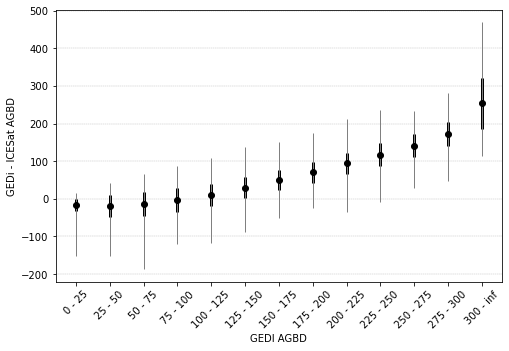

In [7]:
import matplotlib.pyplot as plt

# Calculate quartiles
q1 = mean - std
q3 = mean + std

gedi_bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]

# Create boxplot
plt.figure(figsize = (8,5))
# plt.boxplot(mean)
# create stacked errorbars:
plt.errorbar(gedi_bins, mean, std, fmt='ok', lw=3)
plt.errorbar(gedi_bins, mean, [mean - min, max - mean],
             fmt='.k', ecolor='gray', lw=1)
xticks = ["" for i in range(len(gedi_bins))]
for i in range(len(gedi_bins)-1):
    xticks[i] = (str(gedi_bins[i]) + " - "+ str(gedi_bins[i+1]) )
xticks[-1] = ("300 - inf" )
plt.xticks(gedi_bins, labels=xticks, rotation=45)
plt.xlabel('GEDI AGBD')
plt.ylabel('GEDi - ICESat AGBD')
plt.grid(axis='y', linestyle='--', linewidth=0.4)
plt.show()



### Histograms

Here the user can visualize the distribution of the ICESat data for different GEDI agb bins.

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0 6650 3220  635  209   77   20    4    0    0    0    0    0    0]
 [   0  597 1691 1148  562  321   96   24    4    0    0    0    0    0]
 [   0  156  771 1025  861  582  246   48   13    0    1    0    0    0]
 [   0   42  318  747  976  886  379   74    9    0    0    0    0    0]
 [   0   24  179  442 1060 1271  718  123   21    1    1    0    0    0]
 [   0   13  103  349 1120 1652  969  175   23    3    1    0    0    0]
 [   0    7   77  299  909 1589 1167  185   31    8    0    0    0    0]
 [   0    6   41  152  587 1094  923  198   33    6    0    0    0    0]
 [   0    5   15   99  325  653  564  141   39    3    1    0    0    0]
 [   0    6   10   51  213  360  314  103   36    4    1    0    0    0]
 [   0    2    3   24  115  197  147   51   21    4    2    0    0    0]
 [   0    4    3   19   73  114   79   24    8    0    2    0    0    0]
 [   0   18   10   23  107  131   82   21    7    0

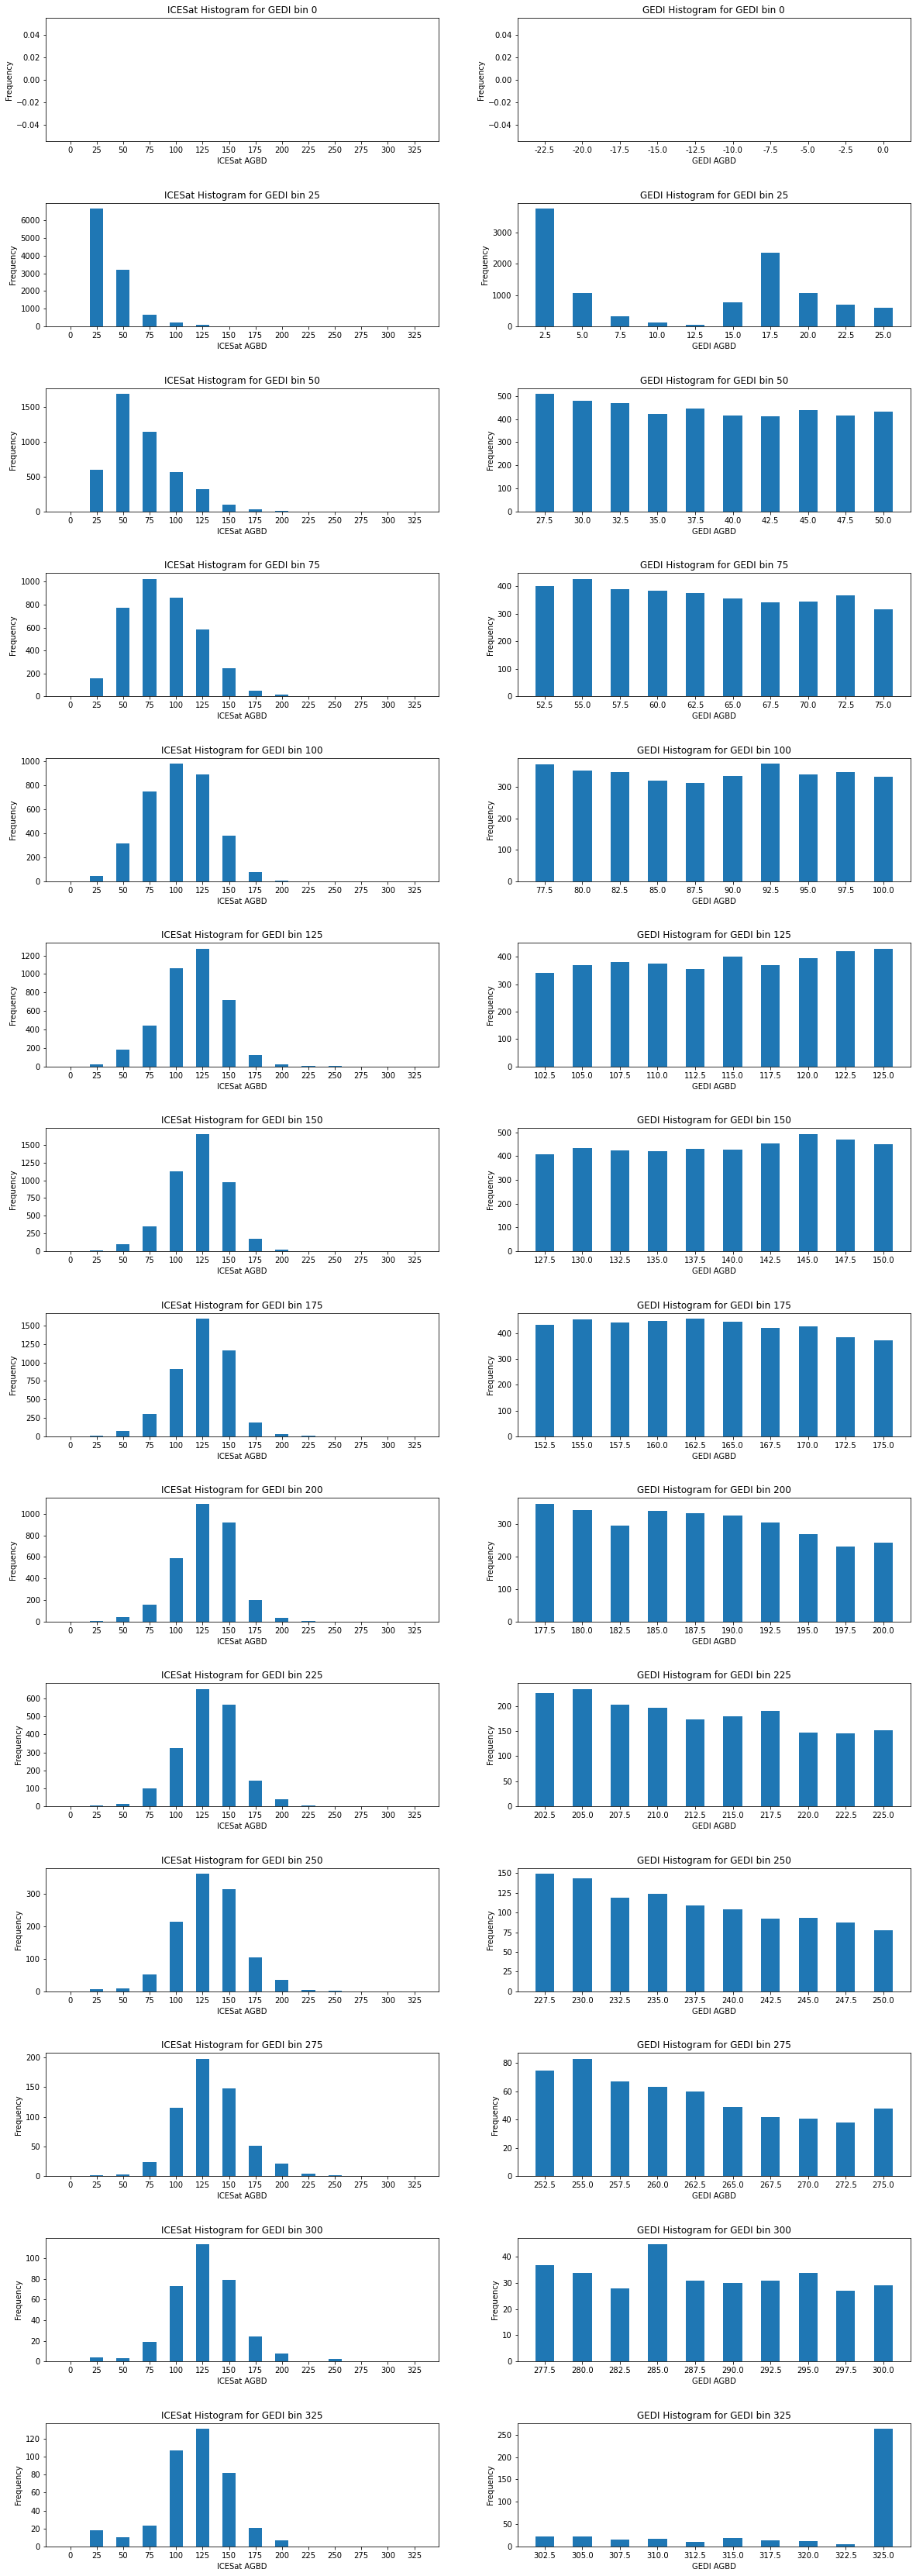

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# print(icesat_histograms.astype(int))

# Create subplots for histograms
fig, axs = plt.subplots(14, 2, figsize=(20, 60))

# Loop over each row in the arrays
for i in range(icesat_histograms.shape[0]):
    # Create a histogram for each row
    axs[i, 0].bar(height = icesat_histograms[i, :], x = np.arange(0,14), width=0.5)
    axs[i,0].set_title(f'ICESat Histogram for GEDI bin {i*25}')
    axs[i,0].set_xlabel('ICESat AGBD')
    axs[i,0].set_ylabel('Frequency')
    axs[i,0].set_xticks(np.arange(0,14))
    axs[i,0].set_xticklabels(np.arange(0,350,25))
    
    axs[i,1].bar(height = gedi_histograms[i, :], x = np.arange(0,10), width=0.5)
    axs[i,1].set_title(f'GEDI Histogram for GEDI bin {i*25}')
    axs[i,1].set_xlabel('GEDI AGBD')
    axs[i,1].set_ylabel('Frequency')
    axs[i,1].set_xticks(np.arange(0,10))
    axs[i,1].set_xticklabels(np.full(10,(i-1)*25)+ np.arange(2.5,27.5,2.5))

plt.subplots_adjust(hspace=0.5)
# Display the histograms
plt.show()

